In [1]:
import os
os.environ['HF_HOME'] = "D:/Workforce_Attire/.cache"

In [2]:
import datasets

full_data = datasets.load_from_disk("data/")
es = datasets.load_dataset("adam-narozniak/clothing")

D:\anaconda\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Loading dataset from disk:   0%|          | 0/48 [00:00<?, ?it/s]

In [3]:
fashionpedia = datasets.load_dataset("detection-datasets/fashionpedia")

In [4]:
import torch
import transformers

MODEL = transformers.YolosForObjectDetection.from_pretrained('checkpoint-44000', local_files_only=True) # from checkpoint
PROCESSOR = transformers.YolosFeatureExtractor.from_pretrained('hustvl/yolos-tiny')


def detect_boxes(image, threshold=0.9):
    inputs = PROCESSOR(image, return_tensors="pt", size={"height": 800, "width": 800})
    outputs = MODEL(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = PROCESSOR.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)[0]
    return results

D:\anaconda\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [8]:
from munkres import Munkres
import numpy as np

def calculate_iou(bb1, bb2):
    # bb1, bb2: list of lists, bounding boxes should be of the form [x1, y1, x2, y2] (absolute, not relative)
    assert bb1[0] < bb1[2] and bb1[1] < bb1[3] and bb2[0] < bb2[2] and bb2[1] < bb2[3]
    o_x1 = max(bb1[0], bb2[0]) 
    o_y1 = max(bb1[1], bb2[1])
    o_x2 = min(bb1[2], bb2[2])
    o_y2 = min(bb1[3], bb2[3])
    overlap_area = rectangle_area(o_x1, o_y1, o_x2, o_y2)
    union_area = rectangle_area(*bb1) + rectangle_area(*bb2)
    iou = overlap_area/(union_area - overlap_area)
    return iou
    
    
def rectangle_area(x1, y1, x2, y2):
    # compute area of a rectangle
    return max((x2 - x1), 0) * max((y2 - y1), 0)

def compare_labels(ground_truth, prediction):
    # function for matching labels between bounding boxes of given ground truths and predictions
    bb_gt = ground_truth['objects']['bbox']
    bb_p = prediction['boxes'].detach().tolist()
    labels_gt = ground_truth['objects']['category']
    labels_p = prediction['labels'].detach().tolist()
    scores_p = prediction['scores']
    
    labels_matched_p = []
    labels_matched_gt = []
    ious = []
    
    # Situation in which we have no ground truths
    if len(labels_gt) == 0:
        for label in labels_p:
            labels_matched_p.append(label)
            labels_matched_gt.append(-1)
            ious.append(-1)
        return labels_matched_gt, labels_matched_p, scores_p, ious
    
    # Situation in which we have no predictions
    if len(labels_p) == 0:
        scores_p = scores_p.detach().tolist()
        for label in labels_gt:
            labels_matched_gt.append(label)
            labels_matched_p.append(-1)
            scores_p.append(0)
            ious.append(-1)
        return labels_matched_gt, labels_matched_p, scores_p, ious
    
    iou_matrix = np.zeros((len(bb_p), len(bb_gt)))
    for i in range(len(bb_p)):
        for j in range(len(bb_gt)):
            iou_matrix[i, j] = calculate_iou(bb_p[i], bb_gt[j])
    
    max_cost = iou_matrix[np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)]
    
    len_diff = len(bb_p) - len(bb_gt)
    if len_diff > 0: # adding padding if there are more predictions than ground truths
        iou_matrix = np.c_[iou_matrix, np.zeros((len(bb_p), len_diff)) + max_cost]
        for i in range(len_diff):
            labels_gt.append(-1)
    
    cost_matrix = max_cost - iou_matrix
    m = Munkres()
    optimal_idxes = m.compute(cost_matrix)
    used_idxes_p = []
    used_idxes_gt = []
    
    for (i_p, i_gt) in optimal_idxes:
        # adding matching labels
        labels_matched_p.append(labels_p[i_p])
        labels_matched_gt.append(labels_gt[i_gt])
        # removing used indexes
        used_idxes_gt.append(i_gt)
        used_idxes_p.append(i_p)
        # adding appropriate iou scores
        ious.append(iou_matrix[(i_p, i_gt)])
        
    # appending leftover predictions
    for i, p in enumerate(labels_p):
        if i in used_idxes_p:
            continue
        labels_matched_p.append(p)
        labels_matched_gt.append(-1)
        used_idxes_p.append(i)
        ious.append(-1)
        
    # rearranging scores
    scores_p = scores_p[used_idxes_p].detach().tolist()

    # appending leftover ground truths
    for i, gt in enumerate(labels_gt):
        if i in used_idxes_gt:
            continue
        labels_matched_p.append(-1)
        labels_matched_gt.append(gt)
        ious.append(-1)
        scores_p.append(0)
    
    return labels_matched_gt, labels_matched_p, scores_p, ious
    
    

In [72]:
%%time
item = 2
labels_matched_gt, labels_matched_p, scores_p, ious = compare_labels(fashionpedia['val'][item], detect_boxes(fashionpedia['val'][item]['image']))

CPU times: total: 10.5 s
Wall time: 2.73 s


In [73]:
fashionpedia['val'][item]

{'image_id': 6410,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x1024>,
 'width': 682,
 'height': 1024,
 'objects': {'bbox_id': [6019,
   6020,
   6021,
   6022,
   6023,
   6024,
   6025,
   6026,
   6027,
   6028,
   6029,
   6030],
  'category': [23, 23, 6, 4, 32, 32, 29, 32, 19, 31, 31, 34],
  'bbox': [[280.0, 902.0, 343.0, 944.0],
   [257.0, 841.0, 276.0, 868.0],
   [231.0, 545.0, 377.0, 911.0],
   [195.0, 236.0, 437.0, 583.0],
   [356.0, 445.0, 391.0, 470.0],
   [238.0, 432.0, 267.0, 457.0],
   [278.0, 236.0, 390.0, 385.0],
   [359.0, 333.0, 393.0, 343.0],
   [261.0, 402.0, 395.0, 441.0],
   [389.0, 290.0, 437.0, 559.0],
   [195.0, 255.0, 257.0, 519.0],
   [288.0, 413.0, 321.0, 441.0]],
  'area': [1907,
   379,
   37715,
   60893,
   589,
   452,
   6898,
   196,
   2522,
   8782,
   9158,
   338]}}

In [74]:
detect_boxes(fashionpedia['val'][item]['image'])

{'scores': tensor([0.9731, 0.9764, 1.0000], grad_fn=<IndexBackward0>),
 'labels': tensor([23, 19,  6]),
 'boxes': tensor([[276.1855, 874.9852, 345.7159, 948.9920],
         [265.8128, 393.4323, 390.4817, 464.4786],
         [228.6266, 516.3261, 390.7021, 911.4119]], grad_fn=<IndexBackward0>)}

In [48]:
from tqdm import tqdm

DATASET = fashionpedia['val']

def assess_model(dataset, threshold=None):
    # compute matching labels, IOUs and bounding box scores for all elements of the dataset
    """
    labels_gt -- ground truth labels, as cloth item names. "None" means that there was a prediction, but no ground truth
    labels_p -- prediction labels, as cloth item names. "None" means that there was ground truth, but no prediction (false negative)
    scores -- confidence scores of bounding boxes. 0 if box is missing
    iou -- IOU scores of bounding boxes. -1 if box is missing
    """
    assessment_dict = {
        "labels_gt":[],
        "labels_p":[],
        "scores":[],
        "iou":[]
    }
    for data in tqdm(dataset):
        labels_gt, labels_p, scores, iou = compare_labels(data, detect_boxes(data['image']))
        assessment_dict['labels_gt'].extend(labels_gt)
        assessment_dict['labels_p'].extend(labels_p)
        assessment_dict['scores'].extend(scores)
        assessment_dict['iou'].extend(iou)
    
    labels_p, labels_gt = translate_labels(assessment_dict['labels_p'], assessment_dict['labels_gt'])
    assessment_dict['labels_gt'] =  np.array(labels_gt)
    assessment_dict['labels_p'] = np.array(labels_p)
    assessment_dict['scores'] = np.array(assessment_dict['scores'])
    assessment_dict['iou'] = np.array(assessment_dict['iou'])
    if threshold is not None:
        assessment_dict = filter_results(assessment_dict, threshold=threshold)
    return assessment_dict

LABEL_DICT = dict()
labs = es["train"].features['objects'].feature['category'].names
LABEL_DICT.update({key:val for key,val in zip(list(range(len(labs))), labs)})

LABEL_DICT[-1] = "none"

def translate_labels(labels_p, labels_gt):
    # translating labels into clothing names
    
    new_labels_p = []
    new_labels_gt = []
    for p, gt in zip(labels_p, labels_gt):
        new_labels_p.append(LABEL_DICT[p])
        new_labels_gt.append(LABEL_DICT[gt])
    return new_labels_p, new_labels_gt

def filter_results(metric_dict, threshold=0.5):
    # filtering results (we take into account with IOU only above a certain threshold)
    for key in metric_dict.keys():
        metric_dict[key] = metric_dict[key][(metric_dict['iou'] > threshold)|(metric_dict['iou'] == -1)]
    return metric_dict

In [49]:
metrics = assess_model(DATASET, 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 1158/1158 [59:23<00:00,  3.08s/it]


In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [51]:
precision_score(metrics['labels_gt'], metrics['labels_p'], labels = list(LABEL_DICT.values()),
               average='weighted')

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.33445351550913843

In [52]:
precision_score(metrics['labels_gt'], metrics['labels_p'], labels = list(LABEL_DICT.values()),
               average=None)

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.0931677 , 0.        , 0.        , 0.        , 0.62037037,
       0.        , 0.85714286, 0.86206897, 0.53125   , 0.66666667,
       0.82926829, 0.        , 0.        , 1.        , 0.77142857,
       0.        , 0.        , 0.        , 0.6       , 0.75      ,
       0.        , 0.        , 0.        , 0.98129252, 0.78571429,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [53]:
recall_score(metrics['labels_gt'], metrics['labels_p'], labels = list(LABEL_DICT.values()),
               average='weighted')

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.1460923076923077

In [54]:
recall_score(metrics['labels_gt'], metrics['labels_p'], labels = list(LABEL_DICT.values()),
               average=None)

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.2970297 , 0.        , 0.        , 0.        , 0.37640449,
       0.        , 0.69306931, 0.24509804, 0.11486486, 0.14285714,
       0.28631579, 0.        , 0.        , 0.49122807, 0.375     ,
       0.        , 0.        , 0.        , 0.04109589, 0.01910828,
       0.        , 0.        , 0.        , 0.45793651, 0.11956522,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

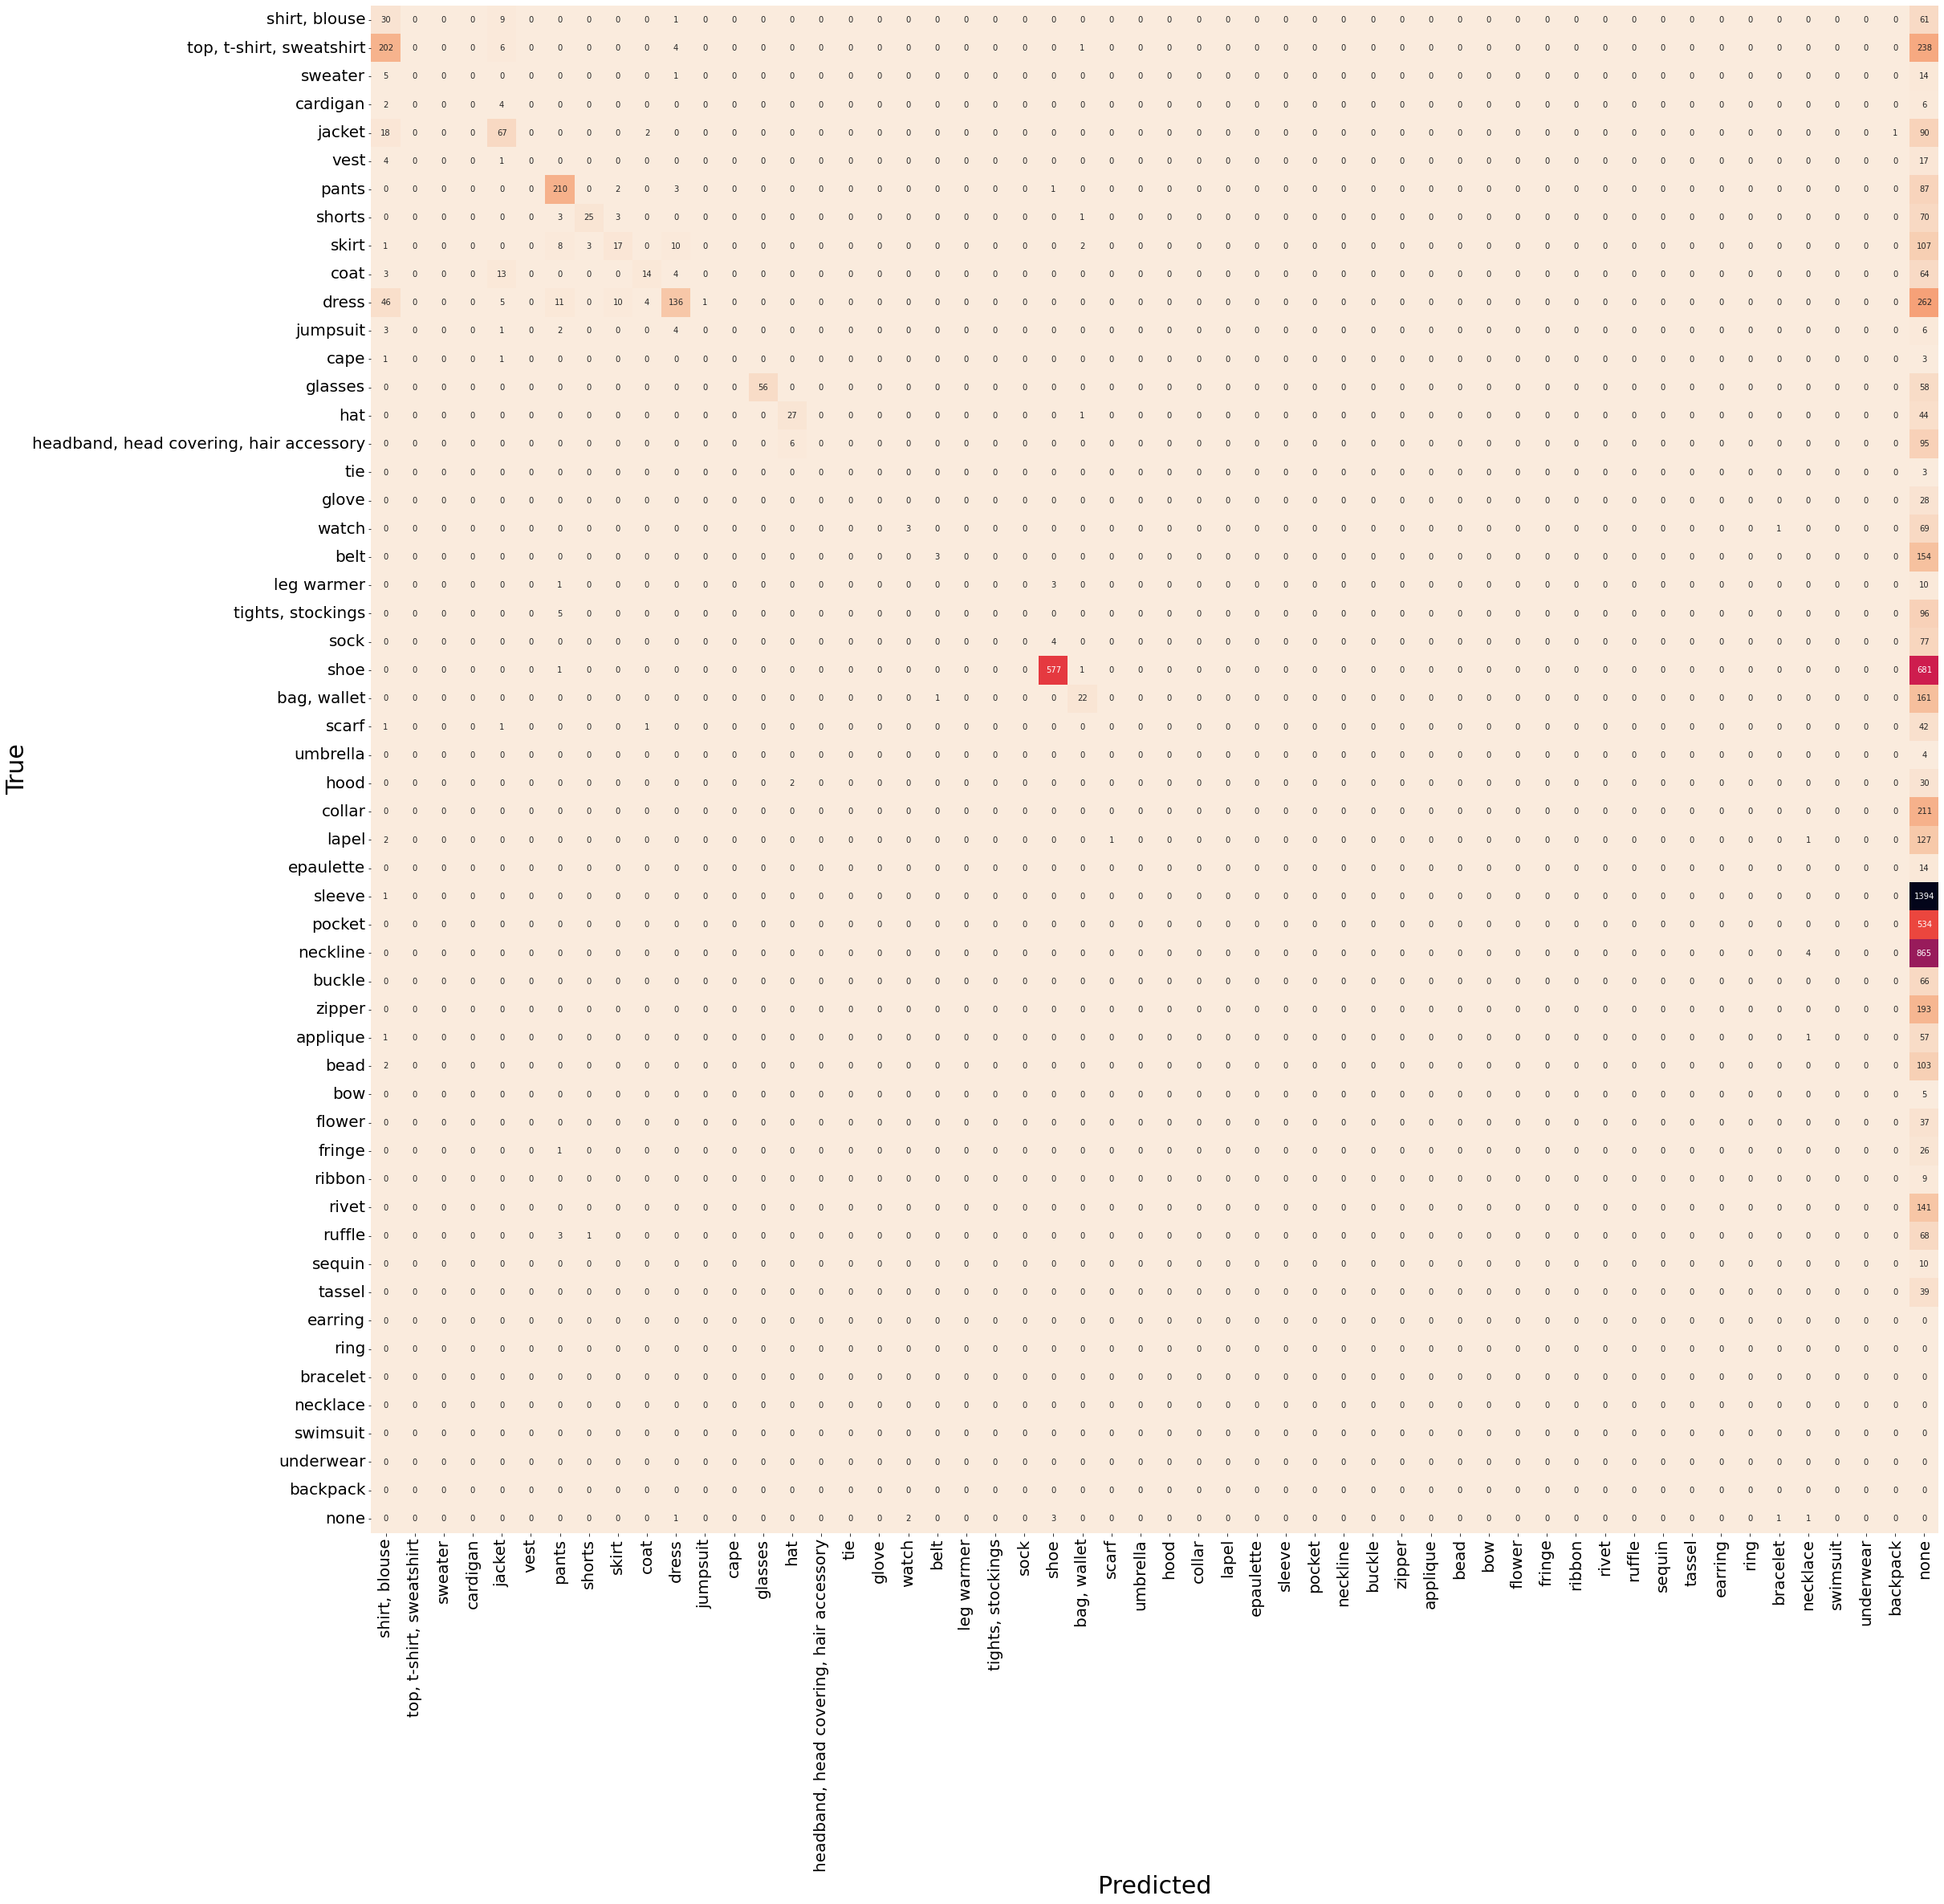

In [55]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = pd.DataFrame(confusion_matrix(metrics['labels_gt'], metrics['labels_p'], labels = list(LABEL_DICT.values())),
                 columns=list(LABEL_DICT.values()),
                 index=list(LABEL_DICT.values())
                 )

plt.figure(figsize=(35,35))

sns.heatmap(cm, annot=True, 
            fmt='.10g',
           cmap=sns.cm.rocket_r,
           cbar=False)
plt.xlabel("Predicted", fontsize=30)
plt.ylabel("True", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
# confusion matrix, AP, mAP, IOUs, false positives etc, top k precision??

In [63]:
def rescale_bboxes_to_img(bboxes, width, height):
    return torch.Tensor(bboxes) / torch.tensor([width, height, width, height], dtype=torch.float32)
    
    
def center_bbox_xy(bbox):
    centered_boxes = []
    for bb in bbox:
        x1, y1, x2, y2 = bb
        width = x2-x1
        height = y2-y1
        xc = x1 + width*0.5
        yc = y1 + height*0.5
        centered_boxes.append(torch.stack([xc, yc, width, height]))
    return torch.stack(centered_boxes)

In [75]:
# TRANSFORMING DATASET FOR SOFTWARE -- (used for producing plots)

import os
from tqdm import tqdm



IMAGE_PATH='metrics_data/images' # path to which we save images from the dataset
ANNOTATIONS_PATH='metrics_data/annots' # path to which we save ground truths from the dataset
DETECTION_PATH='metrics_data/dcs' # path to which we save predictions 
CLASSES_PATH='metrics_data/spanish.names' # path to file with all classes names

for path in [IMAGE_PATH, ANNOTATIONS_PATH, DETECTION_PATH]:
    if not os.path.exists(path):
        os.mkdir(path)

        
with open(CLASSES_PATH, "w") as f:
    for cls in es["train"].features['objects'].feature['category'].names:
        f.write(f"{cls}\n")        

for i, data in enumerate(tqdm(DATASET)):
    image = data['image']
    image.save(os.path.join(IMAGE_PATH, f"{i}.jpg")) # saving image
    results = detect_boxes(image) # model inference
    annotations = data['objects'] 
    width = data["width"]
    height = data["height"]
    boxes = center_bbox_xy(rescale_bboxes_to_img(annotations['bbox'], width, height))
    with open(os.path.join(ANNOTATIONS_PATH, f"{i}.txt"), "w") as f:
        for box, label in zip(boxes, annotations['category']): # saving ground truths
            f.write(f"{label} {box[0]} {box[1]} {box[2]} {box[3]}\n")
    
    idxes = np.argsort(results['scores'].detach().numpy())[::-1] # indexes for sorting by prediction score
    
    with open(os.path.join(DETECTION_PATH, f"{i}.txt"), "w") as f:
        for score, label, box in zip(results["scores"].detach().numpy()[idxes], \
                                     results["labels"].detach().numpy()[idxes], \
                                     results["boxes"].detach().numpy()[idxes]):
            f.write(f"{label} {score} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])}\n") # saving predictions

100%|████████████████████████████████████████████████████████████████████████████| 1158/1158 [1:00:12<00:00,  3.12s/it]


Software used for computing metrics: [Object detection metrics](https://github.com/rafaelpadilla/review_object_detection_metrics)